In [1]:
!pip install eagleSqlTools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import eagleSqlTools as sql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable

con = sql.connect("vwg533", password = "FZtn087h")

In [2]:
sim_name = 'RefL0100N1504'
sim_size = 100.

Query_IDs = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr, \
            SH.GalaxyID as id \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 27 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Data_IDs = sql.execute_query(con, Query_IDs)

In [3]:
for i in range(len(Data_IDs['id'])):
  print('ID:' ,Data_IDs['id'][i])
  print('u-r:' ,Data_IDs['u_minus_r'][i])
  print('Mass:' ,Data_IDs['mass'][i])
  print('sSFR:' ,Data_IDs['ssfr'][i])
  print('')

ID: 10088971
u-r: 1.151638
Mass: 10.252948852071313
sSFR: 1.2342698e-10

ID: 10106169
u-r: 1.435276
Mass: 10.032452651010317
sSFR: 6.542472e-11

ID: 10118201
u-r: 1.30303
Mass: 10.032907370367157
sSFR: 9.618428e-11

ID: 10149790
u-r: 1.5682812
Mass: 10.181585838615018
sSFR: 4.631627e-11

ID: 10166065
u-r: 1.272604
Mass: 10.040505923315033
sSFR: 9.703199e-11

ID: 10198004
u-r: 2.2555618
Mass: 10.245301223905656
sSFR: 3.4118624e-12

ID: 10307103
u-r: 1.5030365
Mass: 9.768307287633448
sSFR: 5.995514e-11

ID: 10336451
u-r: 1.3792114
Mass: 9.48837308193531
sSFR: 7.399517e-11

ID: 10376427
u-r: 1.4881725
Mass: 10.091104669721323
sSFR: 5.9322894e-11

ID: 10423373
u-r: 1.4100685
Mass: 10.02674317339317
sSFR: 7.864604e-11

ID: 10434383
u-r: 1.2674313
Mass: 9.920154915054347
sSFR: 1.0167059e-10

ID: 10438464
u-r: 1.4350243
Mass: 10.129573765145608
sSFR: 8.0549394e-11

ID: 10466957
u-r: 1.4772644
Mass: 9.930311745753219
sSFR: 6.782652e-11

ID: 10476385
u-r: 1.3536739
Mass: 10.081091842751725
sSFR

Mass: 9.550179321743489
sSFR: 5.4712738e-11

ID: 12066078
u-r: 1.6338272
Mass: 9.394803636121091
sSFR: 3.9513087e-11

ID: 12219466
u-r: 1.2895222
Mass: 9.219809877575315
sSFR: 8.331741e-11

ID: 12237807
u-r: 1.9251461
Mass: 9.614882211953718
sSFR: 1.8540844e-11

ID: 3873360
u-r: 1.4652958
Mass: 9.075892040929604
sSFR: 7.748511e-11

ID: 3884020
u-r: 1.30517
Mass: 9.193525478665185
sSFR: 9.8646424e-11

ID: 3903810
u-r: 1.5516815
Mass: 9.138893184680343
sSFR: 4.4491244e-11

ID: 3939706
u-r: 1.7084923
Mass: 9.360122050957724
sSFR: 3.209837e-11

ID: 3963272
u-r: 1.3634357
Mass: 9.026539226124035
sSFR: 9.671939e-11

ID: 16725169
u-r: 1.8642178
Mass: 10.155677597025448
sSFR: 1.5788478e-11

ID: 16874413
u-r: 1.690237
Mass: 10.707047540989564
sSFR: 3.5125288e-11

ID: 17022392
u-r: 1.3917732
Mass: 10.702636663518481
sSFR: 8.309616e-11

ID: 17047719
u-r: 1.3628349
Mass: 10.693564231942965
sSFR: 7.39599e-11

ID: 12839162
u-r: 0.9389038
Mass: 9.359745631361932
sSFR: 2.7182873e-10

ID: 12840064
u-r:

Mass: 9.048480237299824
sSFR: 8.479431e-11

ID: 4243233
u-r: 1.1297817
Mass: 9.043954319568371
sSFR: 1.4138538e-10

ID: 16157604
u-r: 1.7189484
Mass: 10.836143523487411
sSFR: 3.4049836e-11

ID: 16161680
u-r: 1.3276005
Mass: 10.745620147856345
sSFR: 8.580191e-11

ID: 16373728
u-r: 1.4662418
Mass: 10.713397794098336
sSFR: 6.252788e-11

ID: 10440278
u-r: 1.5941277
Mass: 9.866780672569114
sSFR: 4.551049e-11

ID: 10443503
u-r: 1.4635963
Mass: 10.032375428482265
sSFR: 6.80258e-11

ID: 10460079
u-r: 2.0083294
Mass: 9.97367722891037
sSFR: 1.25202826e-11

ID: 10473451
u-r: 1.690958
Mass: 10.270764227229977
sSFR: 3.5368784e-11

ID: 10489108
u-r: 1.2453156
Mass: 9.963041511139542
sSFR: 1.2228567e-10

ID: 10541605
u-r: 1.2683144
Mass: 9.994681925781183
sSFR: 1.0700555e-10

ID: 10790387
u-r: 1.1566181
Mass: 9.654630648441366
sSFR: 1.2685769e-10

ID: 10797905
u-r: 1.1224232
Mass: 9.561720461844153
sSFR: 1.7043451e-10

ID: 11121227
u-r: 1.5795174
Mass: 9.793080670084775
sSFR: 3.5048315e-11

ID: 11126

Mass: 9.587262899367323
sSFR: 1.2749024e-10

ID: 12057892
u-r: 1.2152748
Mass: 9.205474292080805
sSFR: 1.2416042e-10

ID: 12083328
u-r: 1.282711
Mass: 9.526403465506716
sSFR: 1.0648885e-10

ID: 12085319
u-r: 1.4811344
Mass: 9.45816252431654
sSFR: 6.6008796e-11

ID: 12112108
u-r: 1.1768456
Mass: 9.363820980533132
sSFR: 1.4112243e-10

ID: 12248248
u-r: 1.4615536
Mass: 9.53297715337755
sSFR: 6.270948e-11

ID: 12248648
u-r: 1.4203663
Mass: 9.360141069568186
sSFR: 7.922143e-11

ID: 3841778
u-r: 1.2618275
Mass: 9.276547298000812
sSFR: 1.0537747e-10

ID: 3882539
u-r: 1.1831894
Mass: 9.266097700642948
sSFR: 1.3687483e-10

ID: 16565965
u-r: 2.3163452
Mass: 10.497098176068267
sSFR: 2.1978448e-12

ID: 16608247
u-r: 2.3793564
Mass: 10.79976026230016
sSFR: 2.5516777e-13

ID: 16639750
u-r: 1.4347973
Mass: 10.719509349669678
sSFR: 6.3549124e-11

ID: 16707700
u-r: 1.8538113
Mass: 10.598586905550034
sSFR: 2.1007031e-11

ID: 16921469
u-r: 2.1382656
Mass: 10.7474494859209
sSFR: 0.0

ID: 16986868
u-r: 1.7

u-r: 1.1907864
Mass: 9.770183535448421
sSFR: 1.2547836e-10

ID: 10353851
u-r: 1.3976555
Mass: 10.075540729696446
sSFR: 7.847528e-11

ID: 10368884
u-r: 1.1252975
Mass: 9.22732600528807
sSFR: 1.9160588e-10

ID: 10397921
u-r: 1.347702
Mass: 9.947303160597116
sSFR: 8.4666815e-11

ID: 10412018
u-r: 0.96271706
Mass: 9.43738639913159
sSFR: 2.831715e-10

ID: 10416105
u-r: 1.6772518
Mass: 9.743411598691862
sSFR: 3.2426593e-11

ID: 11412576
u-r: 1.270338
Mass: 9.83735321721511
sSFR: 1.06453076e-10

ID: 11414198
u-r: 1.3110924
Mass: 9.57045942776473
sSFR: 8.3093435e-11

ID: 11424980
u-r: 1.8032246
Mass: 9.975246464103602
sSFR: 2.4829434e-11

ID: 11588685
u-r: 1.006773
Mass: 9.47694944858756
sSFR: 1.993438e-10

ID: 11606383
u-r: 1.1462612
Mass: 9.368957407228855
sSFR: 1.2650646e-10

ID: 11615257
u-r: 1.1318779
Mass: 9.38595845046715
sSFR: 1.685805e-10

ID: 11662864
u-r: 1.3409004
Mass: 9.588024064860303
sSFR: 8.3817724e-11

ID: 11673660
u-r: 1.3639984
Mass: 9.367361193664529
sSFR: 8.10913e-11

ID:


ID: 13422733
u-r: 2.0786753
Mass: 9.052273368986112
sSFR: 1.8772269e-12

ID: 13444023
u-r: 1.1487103
Mass: 9.294309305075785
sSFR: 1.4032181e-10

ID: 13485152
u-r: 1.8626308
Mass: 9.46081425782122
sSFR: 1.6917521e-11

ID: 13536713
u-r: 1.4836426
Mass: 9.361428708813786
sSFR: 5.4749254e-11

ID: 13537045
u-r: 1.9395475
Mass: 9.199712886317604
sSFR: 9.365901e-12

ID: 13570035
u-r: 1.3681507
Mass: 9.212272992691961
sSFR: 6.908758e-11

ID: 13599851
u-r: 1.7415743
Mass: 9.052078400293043
sSFR: 2.6630781e-11

ID: 13624417
u-r: 1.6794786
Mass: 9.035325847322467
sSFR: 2.8478024e-11

ID: 13669243
u-r: 1.5338001
Mass: 9.239085702571861
sSFR: 5.1278065e-11

ID: 13767426
u-r: 1.9752369
Mass: 9.115901503951903
sSFR: 1.504091e-11

ID: 3588547
u-r: 1.329876
Mass: 9.213112341059258
sSFR: 9.9886814e-11

ID: 14632181
u-r: 1.959095
Mass: 11.07033175099825
sSFR: 1.2878832e-11

ID: 15076082
u-r: 1.5063019
Mass: 11.06870417471454
sSFR: 5.3904273e-11

ID: 15101699
u-r: 1.4855175
Mass: 10.690031099326427
sSFR

sSFR: 2.9105513e-11

ID: 12025373
u-r: 1.1995163
Mass: 9.392785010109819
sSFR: 1.2348365e-10

ID: 12027781
u-r: 0.74717903
Mass: 9.432553851583538
sSFR: 5.040498e-10

ID: 12033036
u-r: 1.5497437
Mass: 9.529746594496569
sSFR: 5.598108e-11

ID: 12046140
u-r: 1.3627357
Mass: 9.4146501233161
sSFR: 8.284972e-11

ID: 12049207
u-r: 1.2595425
Mass: 9.251038980092948
sSFR: 9.9029625e-11

ID: 12067932
u-r: 1.9245434
Mass: 9.71457477892094
sSFR: 1.7488113e-11

ID: 12073271
u-r: 1.5080051
Mass: 9.25355227678579
sSFR: 5.949118e-11

ID: 12223483
u-r: 1.4746532
Mass: 9.580385829662609
sSFR: 5.7376263e-11

ID: 12260285
u-r: 1.1971359
Mass: 9.361609196241735
sSFR: 1.3585069e-10

ID: 12262991
u-r: 1.2017193
Mass: 9.237852234989909
sSFR: 1.4208675e-10

ID: 12273721
u-r: 1.259737
Mass: 9.34732795412117
sSFR: 9.38577e-11

ID: 12297092
u-r: 1.5913277
Mass: 9.546088106272792
sSFR: 4.10937e-11

ID: 12313799
u-r: 0.9816971
Mass: 9.348293371035671
sSFR: 2.6427807e-10

ID: 12325261
u-r: 0.84690094
Mass: 9.043933

ID: 10778346
u-r: 1.4180679
Mass: 9.781897504806079
sSFR: 6.9339263e-11

ID: 10099700
u-r: 1.2749062
Mass: 10.185813770420499
sSFR: 1.0606622e-10

ID: 10100572
u-r: 1.3060169
Mass: 10.13606139015078
sSFR: 9.221364e-11

ID: 10115994
u-r: 1.3048058
Mass: 9.206816933249923
sSFR: 7.2096704e-11

ID: 10123231
u-r: 1.2386608
Mass: 10.03628279339577
sSFR: 1.2405382e-10

ID: 10158009
u-r: 1.30653
Mass: 10.10511119018171
sSFR: 9.22284e-11

ID: 10176512
u-r: 1.3584518
Mass: 10.036878936115901
sSFR: 8.654067e-11

ID: 10194560
u-r: 1.1778088
Mass: 9.881486203834836
sSFR: 1.5238122e-10

ID: 10202983
u-r: 1.3376713
Mass: 10.037027772558005
sSFR: 7.792057e-11

ID: 10280514
u-r: 1.1351109
Mass: 9.953779385744351
sSFR: 1.6686316e-10

ID: 10299316
u-r: 1.3661957
Mass: 9.818083482927348
sSFR: 7.77119e-11

ID: 10354999
u-r: 1.8706417
Mass: 10.073386745016474
sSFR: 2.2814804e-11

ID: 11404144
u-r: 1.6755104
Mass: 9.540043245757913
sSFR: 3.891982e-11

ID: 11428625
u-r: 1.6352749
Mass: 9.767658970121204
sSFR:

sSFR: 1.2841418e-10

ID: 10252691
u-r: 1.3330879
Mass: 9.942360183705182
sSFR: 7.9650196e-11

ID: 10253645
u-r: 1.1964321
Mass: 9.480588073713307
sSFR: 1.458426e-10

ID: 10293603
u-r: 1.0605984
Mass: 9.755779601552
sSFR: 1.9756184e-10

ID: 10294382
u-r: 1.4140129
Mass: 10.18999246858635
sSFR: 6.670445e-11

ID: 10302220
u-r: 1.5117874
Mass: 10.122913268668292
sSFR: 5.981473e-11

ID: 10331432
u-r: 1.269249
Mass: 9.815694708928845
sSFR: 1.0326321e-10

ID: 10336912
u-r: 1.5955849
Mass: 9.895343567545602
sSFR: 4.583615e-11

ID: 10342996
u-r: 0.7903137
Mass: 9.918707653494543
sSFR: 3.6828465e-10

ID: 10417879
u-r: 1.5989971
Mass: 10.114709932860912
sSFR: 4.067878e-11

ID: 10464464
u-r: 1.8193798
Mass: 10.099379654302995
sSFR: 2.7012228e-11

ID: 10470998
u-r: 0.94750977
Mass: 9.247313981217621
sSFR: 3.324047e-10

ID: 10472334
u-r: 1.0294895
Mass: 9.900275301557036
sSFR: 2.0826181e-10

ID: 10518755
u-r: 0.9005165
Mass: 9.629914623497235
sSFR: 2.1889601e-10

ID: 10704127
u-r: 1.3339787
Mass: 9.

u-r: 1.5123672
Mass: 10.61109452640669
sSFR: 5.670791e-11

ID: 16916061
u-r: 2.3704681
Mass: 10.827120027361165
sSFR: 0.0

ID: 16925428
u-r: 1.677721
Mass: 10.67767583176424
sSFR: 3.375473e-11

ID: 17120126
u-r: 2.197918
Mass: 10.544451812107285
sSFR: 0.0

ID: 12558660
u-r: 1.9449883
Mass: 9.258273775070524
sSFR: 5.8824104e-12

ID: 12563074
u-r: 1.160532
Mass: 9.4175578752494
sSFR: 1.5299849e-10

ID: 12600065
u-r: 1.009489
Mass: 9.111108366892267
sSFR: 2.5180247e-10

ID: 12606458
u-r: 1.7502422
Mass: 9.324674778162125
sSFR: 2.7876194e-11

ID: 12611897
u-r: 1.1785355
Mass: 9.276253219208531
sSFR: 1.3838462e-10

ID: 12612174
u-r: 1.2094994
Mass: 9.1043311087555
sSFR: 1.2399617e-10

ID: 12616820
u-r: 1.2949009
Mass: 9.2525885111983
sSFR: 8.37942e-11

ID: 12617613
u-r: 0.7842121
Mass: 9.340825840611444
sSFR: 4.8271653e-10

ID: 12804232
u-r: 1.0332413
Mass: 9.454056741708435
sSFR: 2.3516838e-10

ID: 12808569
u-r: 1.4175434
Mass: 9.134421763910645
sSFR: 6.4976066e-11

ID: 12816357
u-r: 1.865

ID: 11078389
u-r: 1.4322891
Mass: 9.75379564968549
sSFR: 6.914803e-11

ID: 11711282
u-r: 1.2338676
Mass: 9.570758729686343
sSFR: 1.2280228e-10

ID: 11720163
u-r: 1.215744
Mass: 9.496377294852005
sSFR: 1.3602551e-10

ID: 11728344
u-r: 1.4457569
Mass: 9.550247347089996
sSFR: 6.649597e-11

ID: 11745206
u-r: 1.2684193
Mass: 9.669554993903704
sSFR: 9.60428e-11

ID: 11756738
u-r: 1.5130234
Mass: 9.808912832703257
sSFR: 5.0592544e-11

ID: 11793413
u-r: 1.3573265
Mass: 9.540770427968873
sSFR: 9.057659e-11

ID: 11807617
u-r: 1.4541626
Mass: 9.524585858381492
sSFR: 6.329485e-11

ID: 11808096
u-r: 1.3451576
Mass: 9.534917291863401
sSFR: 9.44421e-11

ID: 11812940
u-r: 1.2658348
Mass: 9.557873831295348
sSFR: 1.09660094e-10

ID: 11815784
u-r: 1.106327
Mass: 9.201128882409321
sSFR: 1.706208e-10

ID: 11819742
u-r: 1.3031502
Mass: 9.50145814984835
sSFR: 1.04807434e-10

ID: 11843392
u-r: 1.4798985
Mass: 9.731142178257905
sSFR: 6.0376655e-11

ID: 11858189
u-r: 1.2330227
Mass: 9.557674600869275
sSFR: 1.33

sSFR: 5.0102953e-11

ID: 4153863
u-r: 1.220726
Mass: 9.063970875030973
sSFR: 1.1781454e-10

ID: 4195328
u-r: 1.4320278
Mass: 9.15985078514555
sSFR: 6.6441345e-11

ID: 4262146
u-r: 2.227934
Mass: 9.205427912827181
sSFR: 0.0

ID: 16049480
u-r: 2.0392113
Mass: 11.050754848922166
sSFR: 1.2113078e-11

ID: 16116800
u-r: 1.428421
Mass: 10.663763670888896
sSFR: 7.0500196e-11

ID: 16398555
u-r: 1.8678894
Mass: 10.875665258814832
sSFR: 2.322369e-11

ID: 16424325
u-r: 2.2442589
Mass: 10.614031799687048
sSFR: 2.5215702e-12

ID: 16437978
u-r: 1.5566139
Mass: 10.957413731737011
sSFR: 5.0237776e-11

ID: 10453374
u-r: 1.0900669
Mass: 9.37091798079049
sSFR: 1.5343675e-10

ID: 10530947
u-r: 1.2834034
Mass: 10.068150197355253
sSFR: 9.978754e-11

ID: 10571791
u-r: 1.0175362
Mass: 9.373593478185969
sSFR: 1.975504e-10

ID: 10784741
u-r: 1.3126163
Mass: 10.046390000675812
sSFR: 9.5753565e-11

ID: 11133604
u-r: 1.2401161
Mass: 9.569066829093186
sSFR: 1.15617314e-10

ID: 11143559
u-r: 1.4451103
Mass: 9.6163425

Mass: 9.2513372622794
sSFR: 2.5559176e-11

ID: 11968189
u-r: 1.1131077
Mass: 9.386849632576858
sSFR: 1.5437725e-10

ID: 3836552
u-r: 1.5109234
Mass: 9.018162399055562
sSFR: 5.3796145e-11

ID: 3848569
u-r: 1.2081013
Mass: 9.014846105637924
sSFR: 1.0244516e-10

ID: 3882179
u-r: 1.2783394
Mass: 9.08821306793115
sSFR: 1.032812e-10

ID: 3895933
u-r: 1.3671818
Mass: 9.241681640692375
sSFR: 7.8037014e-11

ID: 3913145
u-r: 1.2706375
Mass: 9.027908407364189
sSFR: 1.07756686e-10

ID: 4021877
u-r: 1.3067245
Mass: 9.121175861897894
sSFR: 8.9997496e-11

ID: 4032409
u-r: 1.365036
Mass: 9.112922295887161
sSFR: 7.947649e-11

ID: 16996938
u-r: 1.28685
Mass: 10.642987353806776
sSFR: 9.993002e-11

ID: 17029975
u-r: 1.5286865
Mass: 10.57358340494778
sSFR: 4.37997e-11

ID: 17076840
u-r: 1.3657417
Mass: 10.678922452774975
sSFR: 7.8956765e-11

ID: 12517058
u-r: 1.3056183
Mass: 9.52310894788801
sSFR: 9.373408e-11

ID: 12568151
u-r: 1.1665344
Mass: 9.275721860666087
sSFR: 1.49174e-10

ID: 12581770
u-r: 1.69458

Mass: 9.645207831367731
sSFR: 1.9297519e-10

ID: 10819138
u-r: 1.2734375
Mass: 9.96589915571795
sSFR: 1.2019824e-10

ID: 10841702
u-r: 2.2713356
Mass: 9.94030065149857
sSFR: 1.9934488e-12

ID: 10900897
u-r: 1.6725483
Mass: 9.8834111512936
sSFR: 3.5956085e-11

ID: 10921003
u-r: 1.079113
Mass: 9.561702161291064
sSFR: 2.1552342e-10

ID: 10927019
u-r: 1.5404701
Mass: 9.943160558131378
sSFR: 4.796153e-11

ID: 10953355
u-r: 1.5007687
Mass: 10.100335301586531
sSFR: 6.3880366e-11

ID: 11021411
u-r: 2.0034466
Mass: 9.910236729404273
sSFR: 1.5369109e-11

ID: 11040110
u-r: 1.1850147
Mass: 9.883823356272359
sSFR: 1.4626353e-10

ID: 11068153
u-r: 0.97216797
Mass: 9.421286359950056
sSFR: 2.9151032e-10

ID: 11075691
u-r: 1.495327
Mass: 9.1051882774707
sSFR: 6.2262646e-11

ID: 11089181
u-r: 1.2568188
Mass: 9.309113202709055
sSFR: 1.0998335e-10

ID: 11094962
u-r: 1.5584679
Mass: 10.022431322233274
sSFR: 4.9618386e-11

ID: 11099642
u-r: 0.9791546
Mass: 9.49921558096708
sSFR: 2.7192185e-10

ID: 11102013


Mass: 10.198644322247299
sSFR: 5.950438e-11

ID: 10571167
u-r: 1.4353428
Mass: 9.535522949905497
sSFR: 7.15212e-11

ID: 10795819
u-r: 1.2802277
Mass: 9.737797904053576
sSFR: 1.1143961e-10

ID: 11121896
u-r: 1.168253
Mass: 9.53695966647839
sSFR: 1.4074142e-10

ID: 11123815
u-r: 1.4083767
Mass: 9.671702944302721
sSFR: 7.5147465e-11

ID: 11126859
u-r: 1.2184792
Mass: 9.86752057767419
sSFR: 1.2171186e-10

ID: 11131084
u-r: 1.4578667
Mass: 9.787489157127698
sSFR: 7.0358636e-11

ID: 11141714
u-r: 1.2718697
Mass: 9.215767721254895
sSFR: 1.1191302e-10

ID: 11149102
u-r: 1.6589489
Mass: 10.042754718204735
sSFR: 3.6958152e-11

ID: 11165729
u-r: 1.3061104
Mass: 9.856910829266395
sSFR: 9.042724e-11

ID: 11187891
u-r: 1.2888222
Mass: 9.693899467763385
sSFR: 1.10390586e-10

ID: 11248125
u-r: 1.4187775
Mass: 9.834007572674999
sSFR: 7.1646473e-11

ID: 11254590
u-r: 1.1538982
Mass: 9.6574963063206
sSFR: 1.6356691e-10

ID: 11270717
u-r: 1.4643517
Mass: 9.586198175355138
sSFR: 6.2984284e-11

ID: 11310208

sSFR: 1.289331e-11

ID: 11154460
u-r: 1.2284603
Mass: 9.948094284883416
sSFR: 1.1580156e-10

ID: 11154992
u-r: 0.96865845
Mass: 9.693211414371657
sSFR: 2.5760838e-10

ID: 11166424
u-r: 1.4190655
Mass: 9.927595305045639
sSFR: 6.662074e-11

ID: 11218299
u-r: 1.2705345
Mass: 9.69072544763756
sSFR: 1.0835616e-10

ID: 11242632
u-r: 1.3388939
Mass: 9.813600090167279
sSFR: 9.475577e-11

ID: 11264492
u-r: 1.1362267
Mass: 9.6570615587221
sSFR: 1.5097854e-10

ID: 11363231
u-r: 1.5192146
Mass: 9.890641225499483
sSFR: 5.1884674e-11

ID: 11378607
u-r: 1.2853088
Mass: 9.899003798708113
sSFR: 1.1747592e-10

ID: 10856358
u-r: 1.183073
Mass: 9.989451093493853
sSFR: 1.3237059e-10

ID: 10883984
u-r: 1.6874008
Mass: 9.969515222841673
sSFR: 3.497312e-11

ID: 10903104
u-r: 1.1598244
Mass: 9.875139393236916
sSFR: 1.3350461e-10

ID: 10909102
u-r: 1.7005386
Mass: 9.826330423455348
sSFR: 3.81037e-11

ID: 10922355
u-r: 0.99676704
Mass: 9.356950184120162
sSFR: 2.4260569e-10

ID: 10955865
u-r: 1.1873951
Mass: 9.99

Mass: 10.691212779435615
sSFR: 7.295286e-11

ID: 14978116
u-r: 2.303362
Mass: 11.309533474195344
sSFR: 2.356418e-12

ID: 15265736
u-r: 1.7021255
Mass: 10.815763976364323
sSFR: 3.116595e-11

ID: 4072921
u-r: 1.5753326
Mass: 9.076339721884967
sSFR: 3.7288655e-11

ID: 4100222
u-r: 1.8032951
Mass: 9.06783997515523
sSFR: 2.0755562e-11

ID: 4140098
u-r: 1.6603336
Mass: 9.049390663837396
sSFR: 4.315642e-11

ID: 4231975
u-r: 2.2339287
Mass: 9.484156066071298
sSFR: 0.0

ID: 16036384
u-r: 1.2878265
Mass: 10.557646160066284
sSFR: 7.24675e-11

ID: 16491889
u-r: 1.2183151
Mass: 10.557936551648558
sSFR: 1.2387194e-10

ID: 3645753
u-r: 1.2126465
Mass: 9.187289853963605
sSFR: 1.2976449e-10

ID: 3658135
u-r: 1.9645958
Mass: 9.535700771605264
sSFR: 1.3937747e-11

ID: 3706742
u-r: 1.1925392
Mass: 9.152732325993034
sSFR: 1.4069909e-10

ID: 3716781
u-r: 1.0936337
Mass: 9.178379481110673
sSFR: 1.9569166e-10

ID: 3730785
u-r: 1.6367054
Mass: 9.284832540811518
sSFR: 3.4949106e-11

ID: 3731728
u-r: 1.5952225
M

u-r: 1.2014122
Mass: 9.544260437365569
sSFR: 1.3229541e-10

ID: 12485985
u-r: 1.276247
Mass: 9.4939130323929
sSFR: 8.391183e-11

ID: 12499666
u-r: 1.3459797
Mass: 9.398402535369453
sSFR: 1.0247193e-10

ID: 3864068
u-r: 1.1283836
Mass: 9.069932611919157
sSFR: 1.6447284e-10

ID: 3902336
u-r: 1.2303524
Mass: 9.171062182494135
sSFR: 1.1545789e-10

ID: 3932788
u-r: 1.3059597
Mass: 9.099715504787998
sSFR: 9.816715e-11

ID: 3986838
u-r: 1.2019596
Mass: 9.145628235090259
sSFR: 1.4242954e-10

ID: 16731732
u-r: 1.4661427
Mass: 10.843254227055024
sSFR: 6.617312e-11

ID: 16745327
u-r: 1.1141739
Mass: 10.806998926967886
sSFR: 1.4697896e-10

ID: 16948258
u-r: 2.127859
Mass: 10.736621134654628
sSFR: 9.832716e-12

ID: 17109600
u-r: 1.6600513
Mass: 10.84821626441458
sSFR: 3.5363733e-11

ID: 1367583
u-r: 1.8141689
Mass: 9.206209221511612
sSFR: 2.343897e-11

ID: 12512627
u-r: 1.2391891
Mass: 9.510742411693451
sSFR: 1.2717219e-10

ID: 12531713
u-r: 1.1865387
Mass: 9.197044105213989
sSFR: 1.2975353e-10

ID

ID: 10799409
u-r: 1.5021133
Mass: 9.79168121034436
sSFR: 6.2335005e-11

ID: 10126314
u-r: 1.3186073
Mass: 10.221908097565265
sSFR: 9.1944605e-11

ID: 10138699
u-r: 1.1204567
Mass: 10.007950594792554
sSFR: 1.6500423e-10

ID: 10142660
u-r: 1.2296047
Mass: 9.798620622437834
sSFR: 1.1345791e-10

ID: 10150867
u-r: 1.1162415
Mass: 10.01934862512703
sSFR: 1.6594293e-10

ID: 10276058
u-r: 1.206625
Mass: 10.095722266345899
sSFR: 1.3177069e-10

ID: 10347871
u-r: 1.4967117
Mass: 10.153781825255143
sSFR: 5.3358828e-11

ID: 10360860
u-r: 1.47155
Mass: 10.040511959486873
sSFR: 6.080646e-11

ID: 10381831
u-r: 1.3650761
Mass: 9.960371563258395
sSFR: 7.743306e-11

ID: 11115643
u-r: 1.0879879
Mass: 9.728028777648168
sSFR: 1.75654e-10

ID: 11146944
u-r: 1.0087471
Mass: 9.414354835873404
sSFR: 2.4992183e-10

ID: 11250696
u-r: 1.5876293
Mass: 9.85282782081031
sSFR: 5.0843208e-11

ID: 11321641
u-r: 1.32864
Mass: 9.755629001629949
sSFR: 8.897437e-11

ID: 11345909
u-r: 1.169836
Mass: 9.925552988172843
sSFR: 1

sSFR: 6.1116875e-11

ID: 19054213
u-r: 2.1388721
Mass: 11.187040527256643
sSFR: 8.318252e-12

ID: 19488333
u-r: 1.3921795
Mass: 11.037574002835381
sSFR: 5.996983e-11

ID: 20089288
u-r: 1.7211342
Mass: 10.991457099456994
sSFR: 3.2102914e-11

ID: 4608114
u-r: 2.2943382
Mass: 9.630208259744485
sSFR: 0.0

ID: 4618760
u-r: 1.4377346
Mass: 9.304555322433846
sSFR: 5.630957e-11

ID: 4669375
u-r: 2.1610918
Mass: 9.025513595167522
sSFR: 0.0

ID: 4714395
u-r: 2.1032505
Mass: 9.052983487874434
sSFR: 0.0

ID: 17718285
u-r: 1.9565849
Mass: 10.6553507748785
sSFR: 1.29296756e-11

ID: 17818557
u-r: 2.2861614
Mass: 10.33149090772259
sSFR: 0.0

ID: 18160043
u-r: 2.2252789
Mass: 10.389448664869773
sSFR: 2.949159e-12

ID: 8946831
u-r: 1.8074017
Mass: 10.35156413314842
sSFR: 2.411406e-11

ID: 8988007
u-r: 2.1718922
Mass: 10.183013957301418
sSFR: 5.956742e-12

ID: 8991644
u-r: 1.6715069
Mass: 10.379107756786293
sSFR: 3.8013502e-11

ID: 9020524
u-r: 2.32452
Mass: 10.392915156625179
sSFR: 1.8328436e-13

ID: 90

ID: 15651343
u-r: 1.7790623
Mass: 10.259892841175034
sSFR: 2.036455e-11

ID: 15904405
u-r: 1.2112255
Mass: 10.676694183076066
sSFR: 1.4762021e-10

ID: 4491593
u-r: 0.89538956
Mass: 9.022486490993163
sSFR: 2.3437915e-10

ID: 17336997
u-r: 1.30653
Mass: 10.419214183321658
sSFR: 8.936541e-11

ID: 17392885
u-r: 2.1982155
Mass: 10.598184649587557
sSFR: 4.172801e-12

ID: 17542161
u-r: 2.0103092
Mass: 10.72902237375894
sSFR: 1.0954432e-11

ID: 17582605
u-r: 2.245531
Mass: 11.014423315802754
sSFR: 3.776194e-12

ID: 17643578
u-r: 2.256506
Mass: 10.336398447651103
sSFR: 0.0

ID: 17651636
u-r: 1.5779877
Mass: 10.59584897995699
sSFR: 3.746722e-11

ID: 6607759
u-r: 1.4408493
Mass: 9.00818825849963
sSFR: 6.1782135e-11

ID: 19784480
u-r: 1.3623238
Mass: 10.94928690738125
sSFR: 6.590203e-11

ID: 17710821
u-r: 1.4154911
Mass: 10.574949595492987
sSFR: 6.9997536e-11

ID: 17802907
u-r: 1.9104385
Mass: 10.377954152298853
sSFR: 1.2759388e-11

ID: 17923941
u-r: 1.8549004
Mass: 10.613559331673011
sSFR: 2.0329

sSFR: 9.604589e-11

ID: 11298727
u-r: 1.4125061
Mass: 9.081682974833361
sSFR: 6.363392e-11

ID: 11353630
u-r: 2.1254692
Mass: 9.818080305319995
sSFR: 7.626974e-12

ID: 11382876
u-r: 1.8244781
Mass: 9.657610342647445
sSFR: 2.7233374e-11

ID: 11421565
u-r: 1.513092
Mass: 9.579335253827107
sSFR: 6.176728e-11

ID: 11587721
u-r: 1.1950741
Mass: 9.27403417415626
sSFR: 1.1902888e-10

ID: 11599889
u-r: 1.7032032
Mass: 9.6683496267944
sSFR: 3.7489664e-11

ID: 11649659
u-r: 1.366045
Mass: 9.747499917065378
sSFR: 8.2745026e-11

ID: 11656190
u-r: 1.4261818
Mass: 9.619487143973988
sSFR: 6.855889e-11

ID: 11661591
u-r: 1.3264027
Mass: 9.56462463507931
sSFR: 8.718458e-11

ID: 11667424
u-r: 1.6940174
Mass: 9.707075975140755
sSFR: 3.2678946e-11

ID: 11676782
u-r: 1.1297035
Mass: 9.31071708342244
sSFR: 1.227103e-10

ID: 11679239
u-r: 1.0019207
Mass: 9.305842867375238
sSFR: 2.7428984e-10

ID: 10826333
u-r: 1.6702118
Mass: 9.913944753162177
sSFR: 3.7593414e-11

ID: 10903713
u-r: 1.8049927
Mass: 9.63584806

Mass: 9.149132052835052
sSFR: 2.8993655e-10

ID: 17204632
u-r: 2.3255825
Mass: 10.875940678943364
sSFR: 2.8961442e-13

ID: 17391093
u-r: 1.1440964
Mass: 10.100568946175045
sSFR: 1.4223929e-10

ID: 17448932
u-r: 1.4682674
Mass: 10.647275313089676
sSFR: 6.205968e-11

ID: 17464778
u-r: 1.7642021
Mass: 10.231907901391315
sSFR: 2.0251606e-11

ID: 17480554
u-r: 1.4886875
Mass: 10.464340123952883
sSFR: 7.43149e-11

ID: 17554490
u-r: 1.4478989
Mass: 10.572969744078831
sSFR: 6.814759e-11

ID: 6394370
u-r: 2.2238855
Mass: 9.0708552589267
sSFR: 0.0

ID: 6625687
u-r: 2.1842566
Mass: 9.129702016191748
sSFR: 0.0

ID: 19316801
u-r: 1.3062477
Mass: 11.086372716356841
sSFR: 7.735343e-11

ID: 4598886
u-r: 1.7301941
Mass: 9.240479020681427
sSFR: 2.7479543e-11

ID: 4623152
u-r: 1.5797186
Mass: 9.025316012887469
sSFR: 4.536451e-11

ID: 4695163
u-r: 1.3453369
Mass: 9.240066467890745
sSFR: 8.243695e-11

ID: 4703202
u-r: 2.1969767
Mass: 9.005789594328299
sSFR: 0.0

ID: 17694923
u-r: 1.7260914
Mass: 10.5353953

u-r: 1.9688797
Mass: 11.120850585410546
sSFR: 1.4490726e-11

ID: 8321505
u-r: 1.2905369
Mass: 9.853027238419473
sSFR: 9.987062e-11

ID: 8429144
u-r: 1.3795471
Mass: 10.318929029381588
sSFR: 6.103305e-11

ID: 8479314
u-r: 1.7065945
Mass: 10.072901681077605
sSFR: 3.5098088e-11

ID: 8519392
u-r: 1.7673817
Mass: 9.766862471976236
sSFR: 2.7776104e-11

ID: 9407315
u-r: 1.6911144
Mass: 10.336669453602736
sSFR: 3.644657e-11

ID: 9410625
u-r: 1.3592815
Mass: 10.215786006191484
sSFR: 8.304625e-11

ID: 9698917
u-r: 1.3411961
Mass: 10.286307329243758
sSFR: 9.1191756e-11

ID: 9706646
u-r: 1.3567486
Mass: 10.312874203918401
sSFR: 8.562432e-11

ID: 9712821
u-r: 1.4171581
Mass: 10.18475841668222
sSFR: 6.974969e-11

ID: 4849600
u-r: 1.8834686
Mass: 9.402177131129388
sSFR: 1.3451062e-11

ID: 18329099
u-r: 1.7465477
Mass: 10.44885081719793
sSFR: 3.023674e-11

ID: 18343512
u-r: 2.2270775
Mass: 10.344472773180462
sSFR: 6.2488284e-14

ID: 18458996
u-r: 2.4016476
Mass: 10.568087614987238
sSFR: 1.3348718e-12


Mass: 10.887856132081954
sSFR: 4.3674297e-11

ID: 17458112
u-r: 1.4311905
Mass: 10.7830483827381
sSFR: 7.087946e-11

ID: 17469551
u-r: 1.512701
Mass: 10.722502070719893
sSFR: 5.8052597e-11

ID: 17500196
u-r: 1.495758
Mass: 10.828748220731235
sSFR: 5.6552384e-11

ID: 17627269
u-r: 1.3750877
Mass: 10.694150219028767
sSFR: 7.925577e-11

ID: 6605640
u-r: 1.9885559
Mass: 9.261370699410545
sSFR: 3.0328763e-12

ID: 19354333
u-r: 1.6984673
Mass: 11.365302781888001
sSFR: 3.2070086e-11

ID: 17689287
u-r: 1.8361721
Mass: 10.371445523424212
sSFR: 2.0839844e-11

ID: 17886931
u-r: 1.5144672
Mass: 10.52969157363606
sSFR: 5.3146973e-11

ID: 17966783
u-r: 2.1305695
Mass: 10.65855849676906
sSFR: 1.0300101e-11

ID: 17997835
u-r: 1.3502045
Mass: 10.558236342032593
sSFR: 9.269897e-11

ID: 18181889
u-r: 1.4009724
Mass: 10.39036195636568
sSFR: 7.6705725e-11

ID: 8929122
u-r: 1.4407558
Mass: 10.197130475318014
sSFR: 6.673276e-11

ID: 8931580
u-r: 1.5330372
Mass: 10.49782424415688
sSFR: 5.1360242e-11

ID: 8939

ID: 8677915
u-r: 2.3310242
Mass: 10.448210513237218
sSFR: 0.0

ID: 8692370
u-r: 1.3804474
Mass: 9.80030080053968
sSFR: 6.998244e-11

ID: 8751045
u-r: 1.0864124
Mass: 10.11323942712367
sSFR: 1.624643e-10

ID: 8778323
u-r: 2.1810513
Mass: 10.318575441605734
sSFR: 7.30816e-12

ID: 8829295
u-r: 1.2651825
Mass: 10.195904092480541
sSFR: 1.2628217e-10

ID: 8831031
u-r: 1.1519299
Mass: 10.112948698049438
sSFR: 1.4055063e-10

ID: 8860264
u-r: 1.3569412
Mass: 10.603307188015053
sSFR: 7.6242686e-11

ID: 5781560
u-r: 2.1948833
Mass: 9.109814253204183
sSFR: 0.0

ID: 13055896
u-r: 1.3385582
Mass: 9.109569368244916
sSFR: 8.554566e-11

ID: 13058702
u-r: 1.435194
Mass: 9.117948240666461
sSFR: 6.6861953e-11

ID: 13071385
u-r: 1.1591892
Mass: 9.075043185521716
sSFR: 1.4839464e-10

ID: 13087482
u-r: 1.4279423
Mass: 9.635383982740125
sSFR: 6.6226066e-11

ID: 13104343
u-r: 1.7472496
Mass: 9.166656032671282
sSFR: 2.2701532e-11

ID: 13117813
u-r: 1.4654388
Mass: 9.256724271407457
sSFR: 6.438316e-11

ID: 13129

Mass: 9.279373451606942
sSFR: 1.1551501e-10

ID: 8496656
u-r: 1.440033
Mass: 10.13779424615983
sSFR: 6.02076e-11

ID: 9365339
u-r: 1.315794
Mass: 10.310113441572796
sSFR: 9.019466e-11

ID: 9537912
u-r: 2.4084053
Mass: 10.61381426420325
sSFR: 0.0

ID: 9611747
u-r: 1.1625309
Mass: 9.914938966321678
sSFR: 1.2995213e-10

ID: 9720429
u-r: 2.3922272
Mass: 10.164200543778197
sSFR: 0.0

ID: 4812059
u-r: 1.204176
Mass: 9.165402649996022
sSFR: 1.197612e-10

ID: 18292453
u-r: 2.3752632
Mass: 10.297079938337959
sSFR: 4.2318024e-13

ID: 18426435
u-r: 1.5883579
Mass: 10.482746206016797
sSFR: 4.749437e-11

ID: 18445256
u-r: 1.8804932
Mass: 10.560016641939992
sSFR: 1.5352651e-11

ID: 18470777
u-r: 1.9863625
Mass: 10.44862568956033
sSFR: 1.34978756e-11

ID: 5975716
u-r: 1.2539597
Mass: 9.285634321267738
sSFR: 1.161299e-10

ID: 8571863
u-r: 1.4354019
Mass: 9.955972100372328
sSFR: 6.9173244e-11

ID: 8668428
u-r: 1.1941948
Mass: 9.820654947232223
sSFR: 1.2006753e-10

ID: 8787255
u-r: 1.9121094
Mass: 10.46

In [4]:
sim_name = 'RefL0100N1504'
sim_size = 100.
galaxy_id_1 = 20391000#10247408
galaxy_id_2 = 11724877

# Red
Query_1 = "SELECT \
            gal.Redshift as z, \
            gal.MassType_Star as mass, \
            gal.MassType_BH as bh\
          FROM \
            %s_Subhalo as gal, \
            %s_Subhalo as ref \
          WHERE \
            ref.GalaxyID=%s and \
            ((gal.SnapNum > ref.SnapNum and ref.GalaxyID \
            between gal.GalaxyID and gal.TopLeafID) or \
            (gal.SnapNum <= ref.SnapNum and gal.GalaxyID \
            between ref.GalaxyID and ref.TopLeafID)) \
          ORDER BY \
            gal.Redshift"%(sim_name, sim_name, galaxy_id_1)

# Blue
Query_2 = "SELECT \
            gal.Redshift as z, \
            gal.MassType_Star as mass, \
            gal.MassType_BH as bh\
          FROM \
            %s_Subhalo as gal, \
            %s_Subhalo as ref \
          WHERE \
            ref.GalaxyID=%s and \
            ((gal.SnapNum > ref.SnapNum and ref.GalaxyID \
            between gal.GalaxyID and gal.TopLeafID) or \
            (gal.SnapNum <= ref.SnapNum and gal.GalaxyID \
            between ref.GalaxyID and ref.TopLeafID)) \
          ORDER BY \
            gal.Redshift"%(sim_name, sim_name, galaxy_id_2)

Data_1 = sql.execute_query(con, Query_1)
Data_2 = sql.execute_query(con, Query_2)
r = 29 - len(Data_1['z'])
b = 29 - len(Data_2['z'])

In [5]:
def log_with_zeros(data): # Replaces zeroes with the smallest nonzero value.
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

def divide_with_zeros(n, d):
  res = np.empty(len(n))
  for i in range(len(n)):
    if d[i] == 0:
      res[i] = 0
    else:
      res[i] = n[i]/d[i]
  return res

def remove_zeros(data):
  out = []
  for i in range(len(data)):
    if data[i] == 0:
      out = out
    else:
      out = out + [data[i]]
  return np.array(out)

In [6]:
Times = np.array([13.62, 13.53, 13.32, 13.25, 13.16, 13.04, 12.86, 12.75, 12.63, 12.46, 12.25, 12.01, 11.66, 11.16,
                  10.86, 10.53, 10.05, 9.49, 8.86, 7.93, 7.37, 6.71, 6.01, 5.19, 4.16, 3.23, 2.29, 1.24, 0.0]) # len = 29

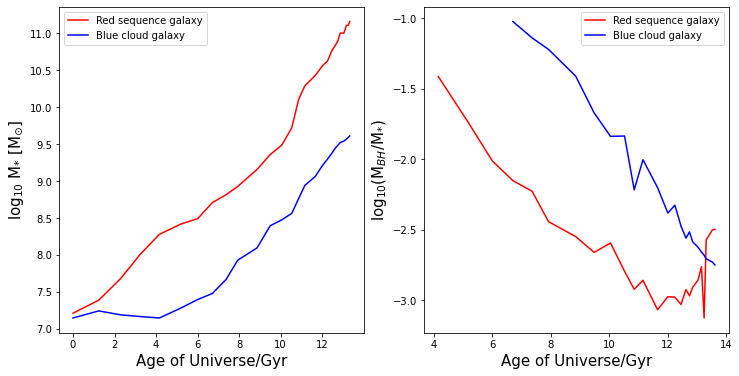

In [7]:
ratio_red = remove_zeros(divide_with_zeros(Data_1['bh'], Data_1['mass']))
ratio_blue = remove_zeros(divide_with_zeros(Data_2['bh'], Data_2['mass']))
r2 = len(ratio_red)
b2 = len(ratio_blue)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
ax1.plot(Times[r:29], log_with_zeros(Data_1['mass']), color = 'r', label = 'Red sequence galaxy')
ax1.plot(Times[b:29], log_with_zeros(Data_2['mass']), color = 'b', label = 'Blue cloud galaxy')
ax2.plot(Times[0:r2], log_with_zeros(ratio_red), color = 'r', label = 'Red sequence galaxy')
ax2.plot(Times[0:b2], log_with_zeros(ratio_blue), color = 'b', label = 'Blue cloud galaxy')
ax1.set_xlabel(r'Age of Universe/Gyr', fontsize=15)
ax1.set_ylabel(r'log$_{10}$ M$_{*}$ [M$_{\odot}$]', fontsize=15)
ax2.set_xlabel(r'Age of Universe/Gyr', fontsize=15)
ax2.set_ylabel(r'log$_{10}$(M$_{BH}$/M$_{*}$)', fontsize=15)
ax1.legend()
ax2.legend()
plt.savefig('Plot_2.jpeg')
plt.show()